In [2]:
print('hi')

hi


In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv("housePrice.csv")

data = data.apply(pd.to_numeric, errors='ignore')


C:\Users\n\AppData\Local\Temp\ipykernel_4664\1752924327.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


In [5]:
data['Area'] = pd.to_numeric(data['Area'], errors='coerce')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3473 non-null   float64
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(3), int64(1), object(1)
memory usage: 146.2+ KB


In [7]:
data['Area'].fillna(data['Area'].median(), inplace=True)
data['Price'].fillna(data['Price'].median(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   float64
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(3), int64(1), object(1)
memory usage: 146.2+ KB


C:\Users\n\AppData\Local\Temp\ipykernel_4664\2392823838.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Area'].fillna(data['Area'].median(), inplace=True)
C:\Users\n\AppData\Local\Temp\ipykernel_4664\2392823838.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

array([[<Axes: title={'center': 'Area'}>,
        <Axes: title={'center': 'Room'}>],
       [<Axes: title={'center': 'Price(USD)'}>, <Axes: >]], dtype=object)

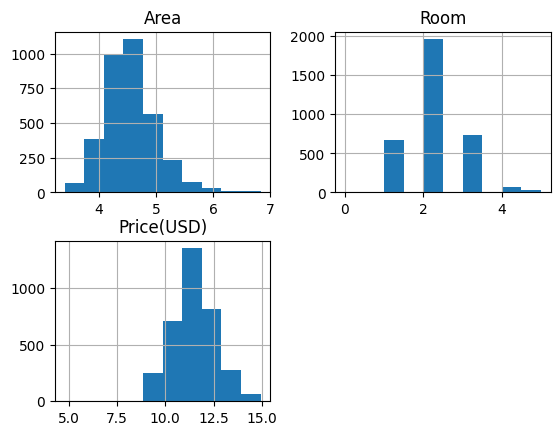

In [8]:
data['Price(USD)'] = np.log(data['Price(USD)'])
data['Area'] = np.log(data['Area'])
data = data.drop(columns=['Price'])
data.hist()

<Axes: >

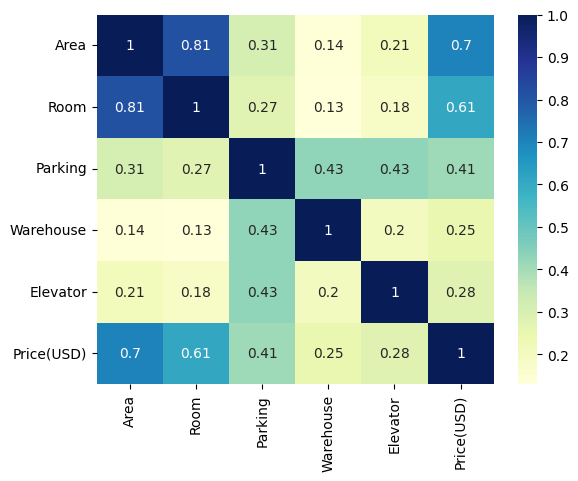

In [9]:
import seaborn as sns

sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='YlGnBu')

In [10]:
data['Address'].value_counts().describe()

count    192.000000
mean      18.000000
std       31.761381
min        1.000000
25%        2.000000
50%        5.000000
75%       16.000000
max      161.000000
Name: count, dtype: float64

In [11]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
X = data[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address']]
y = data['Price(USD)']

In [13]:
bin_cols = ['Room', 'Parking', 'Warehouse', 'Elevator']
X[bin_cols] = X[bin_cols].fillna(X[bin_cols].mode().iloc[0])

C:\Users\n\AppData\Local\Temp\ipykernel_4664\574236714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bin_cols] = X[bin_cols].fillna(X[bin_cols].mode().iloc[0])


In [14]:
X['Address'] = X['Address'].fillna('Unknown')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ['Address']

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,
    random_seed=42,
    verbose=200
)

C:\Users\n\AppData\Local\Temp\ipykernel_4664\3749727265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Address'] = X['Address'].fillna('Unknown')


In [15]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)

0:	learn: 1.0661097	test: 1.0161929	best: 1.0161929 (0)	total: 153ms	remaining: 2m 33s
200:	learn: 0.3763538	test: 0.3635927	best: 0.3632592 (197)	total: 6.75s	remaining: 26.9s
400:	learn: 0.3329651	test: 0.3600139	best: 0.3597227 (389)	total: 13.3s	remaining: 19.8s
600:	learn: 0.3052631	test: 0.3593706	best: 0.3585201 (505)	total: 19.7s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.358520089
bestIteration = 505

Shrink model to first 506 iterations.


In [16]:
y_pred_log = model.predict(X_valid)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE:  {mae:,.2f} USD")
print(f"RMSE: {rmse:,.2f} USD")

MAE:  42,742.33 USD
RMSE: 132,626.82 USD


In [17]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

  Feature Id  Importances
0    Address    48.098058
1       Area    31.123496
2       Room     9.909225
3   Elevator     5.186650
4    Parking     4.114568
5  Warehouse     1.568002


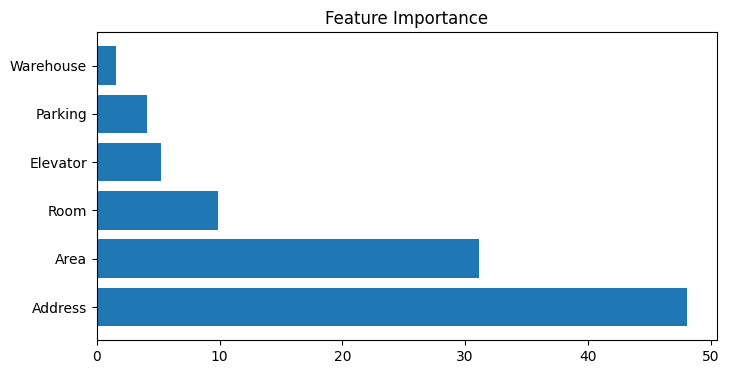

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.title("Feature Importance")
plt.show()

In [19]:
print(model.get_params())         # shows hyperparameters
print(model.get_best_iteration()) # best iteration based on validation RMSE
print(model.get_best_score())

{'iterations': 1000, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 200, 'eval_metric': 'RMSE', 'cat_features': ['Address']}
505
{'learn': {'RMSE': 0.3045657681545863}, 'validation': {'RMSE': 0.35852008903964633}}


In [20]:
new_house = pd.DataFrame({
    'Area': [58],
    'Room': [1],
    'Parking': [1],
    'Warehouse': [0],
    'Elevator': [1],
    'Address': ['Saadat Abad']
})

new_pool = Pool(new_house, cat_features=cat_features)
pred_log = model.predict(new_pool)

pred_price = np.exp(pred_log)
print(f"Predicted price (USD): {pred_price[0]:,.2f}")


Predicted price (USD): 366,864.34


In [21]:
test_pool = Pool(X_train, cat_features=cat_features)

In [22]:
y_pred_log = model.predict(test_pool)

y_pred = np.exp(y_pred_log) 
y_true = np.exp(y_train)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R²: {r2:.4f}")

print(f"Test MAE:  {mae:,.2f} USD")
print(f"Test RMSE: {rmse:,.2f} USD")

R²: 0.8951
Test MAE:  36,541.28 USD
Test RMSE: 90,190.68 USD


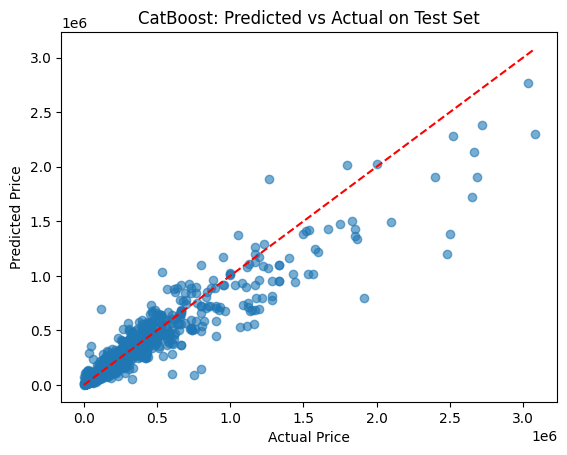

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("CatBoost: Predicted vs Actual on Test Set")
plt.show()